In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np


from datetime import date

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,precision_score, accuracy_score, recall_score, f1_score
from scipy import interp

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#List to keep different methods scores to compare
ScoreSummaryByMethod=[]

In [3]:
#data
df=pd.read_csv('../input/Combined_News_DJIA.csv')
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)

In [4]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined']]
train.head()

,Label,Combined
0,0,"[ 'b""Georgia \'downs two Russian warplanes\' a..."
1,1,"[ ""b'Why wont America and Nato help us? If the..."
2,0,"[ ""b'Remember that adorable 9-year-old who san..."
3,0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,1,"[""b'All the experts admit that we should legal..."


In [5]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Combined']]
test.head()

,Label,Combined
1611,1,[ 'Most cases of cancer are the result of shee...
1612,0,[ 'Moscow-&gt;Beijing high speed train will re...
1613,0,"['US oil falls below $50 a barrel'\n ""Toyota g..."
1614,1,"[""'Shots fired' at French magazine HQ""\n '90% ..."
1615,1,[ 'New Charlie Hebdo issue to come out next we...


I run different classification models on the same data to compare the results. So I combine text processing, plotting and evaluation in specific functions.

In [6]:
#Text pre-processing

def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    2. Removes  stopwords
    3. Stems
    4. Returns a list of the cleaned text
    """
    if pd.isnull(text):
        return []
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed
    

In [7]:
def ROCCurves (Actual, Predicted):
    '''
    Plot ROC curves for the multiclass problem
    based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Compute ROC curve and ROC area for each class
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Actual.values, Predicted)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Actual.ravel(), Predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

In [8]:
def heatmap(data, rotate_xticks=True):
  fig, ax = plt.subplots()
  heatmap = sns.heatmap(data, cmap=plt.cm.Blues)
  ax.xaxis.tick_top()
  if rotate_xticks:
      plt.xticks(rotation=90)
  plt.yticks(rotation=0)

In [9]:
def plot_classification_report(classification_report):
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)
    aveTotal = lines[len(lines) - 1].split()
    classes.append('avg/total')
    vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
    plotMat.append(vAveTotal)
    df_classification_report = DataFrame(plotMat, index=classes,columns=['precision', 'recall', 'f1-score'])
    heatmap(df_classification_report)

In [10]:
def plot_confusion_matrix(confusion_matrix,classes=['0','1']):
    df_confusion_matrix = DataFrame(confusion_matrix, index=classes,columns=classes)
    heatmap(df_confusion_matrix,False)

In [11]:
def Evaluation (Method,Comment,Actual, Predicted):
    '''
        Prints and plots
        - classification report
        - confusion matrix
        - ROC-AUC
    '''
    print (Method)
    print (Comment)
    print (classification_report(Actual,Predicted))
    #plot_classification_report(classification_report(Actual,Predicted))
    print ('Confussion matrix:\n', confusion_matrix(Actual,Predicted))
    #plot_confusion_matrix(confusion_matrix(Actual,Predicted))
    ROC_AUC=roc_auc_score(Actual,Predicted)
    print ('ROC-AUC: ' + str(ROC_AUC))
    #ROCCurves (Actual,Predicted)
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)
    ScoreSummaryByMethod.append([Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1])

In [12]:
#Creating a Data Pipeline for Naive Bayes classifier classifier - baseline
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
nb_pipeline.fit(train['Combined'],train['Label'])
predictions = nb_pipeline.predict(test['Combined'])
Evaluation ('MultinomialNB','no shift, no n-grams, combined Top news',test["Label"], predictions)

MultinomialNB
no shift, no n-grams, combined Top news
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       186
          1       0.51      1.00      0.67       192

avg / total       0.26      0.51      0.34       378

Confussion matrix:
 [[  0 186]
 [  0 192]]
ROC-AUC: 0.5


/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1125: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
#Creating a Data Pipeline for Bernoulli Naive Bayes classifier classifier and n-grams, default alpha=1
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', BernoulliNB(binarize=0.0)),  # train on TF-IDF vectors w/ Bernoulli Naive Bayes classifier
])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
Evaluation ('BernoulliNB(binarize=0.0)','default alpha=1,no shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(binarize=0.0)
default alpha=1,no shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

          0       0.48      0.21      0.29       186
          1       0.51      0.78      0.61       192

avg / total       0.49      0.50      0.46       378

Confussion matrix:
 [[ 39 147]
 [ 42 150]]
ROC-AUC: 0.495463709677


In [14]:
#1 days shift
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)

In [15]:
#new train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined']]
train.head()

,Label,Combined
0,1.0,"[ 'b""Georgia \'downs two Russian warplanes\' a..."
1,0.0,"[ ""b'Why wont America and Nato help us? If the..."
2,0.0,"[ ""b'Remember that adorable 9-year-old who san..."
3,1.0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,1.0,"[""b'All the experts admit that we should legal..."


In [16]:
#new test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Combined']]
test.tail()

,Label,Combined
1983,0.0,['David Cameron to Resign as PM After EU Refer...
1984,1.0,[ 'Barclays and RBS shares suspended from trad...
1985,1.0,"[ '2,500 Scientists To Australia: If You Want ..."
1986,1.0,['Explosion At Airport In Istanbul'\n 'Yemeni ...
1987,1.0,[ 'Jamaica proposes marijuana dispensers for t...


****The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and  1-day shift is smoothing alpha = 0****

In [17]:
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 1-day shift is smoothing alpha = 0 
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.0, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
Evaluation ('BernoulliNB(alpha=0.0,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(alpha=0.0,binarize=0.0)
1-day shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

        0.0       0.52      0.95      0.67       186
        1.0       0.76      0.15      0.25       191

avg / total       0.64      0.55      0.46       377

Confussion matrix:
 [[177   9]
 [162  29]]
ROC-AUC: 0.551722681979


**2-days shift produces with any smoothing alpha gives worse results then 3-days shift
I skip 2-days shift and demo the best result for 3-days shift**
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 3-day shift is smoothing alpha = 0.5 

In [18]:
#3 days shift
df.Label = df.Label.shift(-2)
df.drop(df.index[len(df)-1], inplace=True)
df.drop(df.index[len(df)-1], inplace=True)

In [19]:
#new train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined']]
train.head()

,Label,Combined
0,0.0,"[ 'b""Georgia \'downs two Russian warplanes\' a..."
1,1.0,"[ ""b'Why wont America and Nato help us? If the..."
2,1.0,"[ ""b'Remember that adorable 9-year-old who san..."
3,0.0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,0.0,"[""b'All the experts admit that we should legal..."


In [20]:
#new test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Combined']]
test.tail()

,Label,Combined
1981,0.0,['German government agrees to ban fracking ind...
1982,1.0,[ 'Today The United Kingdom decides whether to...
1983,1.0,['David Cameron to Resign as PM After EU Refer...
1984,1.0,[ 'Barclays and RBS shares suspended from trad...
1985,1.0,"[ '2,500 Scientists To Australia: If You Want ..."


In [21]:
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 3-day shift is smoothing alpha = 0.5 
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
3-days shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

        0.0       0.56      0.40      0.47       184
        1.0       0.55      0.70      0.62       191

avg / total       0.56      0.55      0.54       375

Confussion matrix:
 [[ 74 110]
 [ 57 134]]
ROC-AUC: 0.551872296836


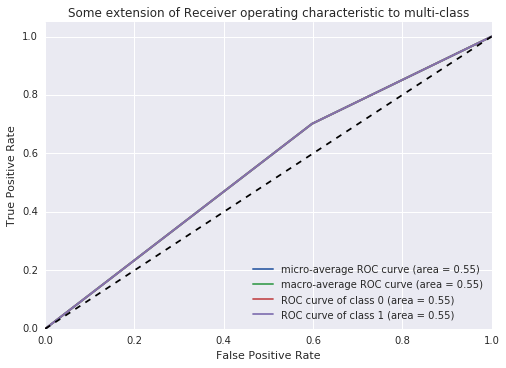

In [22]:
ROCCurves (test["Label"], predictions)

**Let's explore different combinations of Top news columns**
*Here are few the best:*

In [23]:
#Here is the pipeline we use for the differenet data sets
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])

In [24]:
#data re-new
df=pd.read_csv('../input/Combined_News_DJIA.csv')

In [25]:
#Combination 10 and 25
df['Combined10_25']=df.iloc[:,[11,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
#Combination 12 and 25
df['Combined12_25']=df.iloc[:,[13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [26]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Top1','Top12','Top25','Combined10_25','Combined12_25','Combined3_12_25']]
train.head()

,Label,Top1,Top12,Top25,Combined10_25,Combined12_25,Combined3_12_25
0,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'Announcing:Class Action Lawsuit on Behalf of...,"b""No Help for Mexico's Kidnapping Surge""","[""b'Did the U.S. Prep Georgia for War with Rus...","[ ""b'Announcing:Class Action Lawsuit on Behalf...",NaN
1,1,b'Why wont America and Nato help us? If they w...,b'Abhinav Bindra wins first ever Individual Ol...,"b""So this is what it's come to: trading sex fo...","['b""Georgia\'s move, a mistake of monumental p...","[ ""b'Abhinav Bindra wins first ever Individual...",NaN
2,0,b'Remember that adorable 9-year-old who sang a...,b'CNN use footage of Tskhinvali ruins to cover...,"b""BBC NEWS | Asia-Pacific | Extinction 'by man...","[""b'U.S. Beats War Drum as Iran Dumps the Doll...","[""b'CNN use footage of Tskhinvali ruins to cov...",NaN
3,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""US warns against Israeli plan to strike agai...",b'2006: Nobel laureate Aleksander Solzhenitsyn...,"['b""92% of CNN readers: Russia\'s actions in G...","[ 'b""US warns against Israeli plan to strike a...",NaN
4,1,b'All the experts admit that we should legalis...,b'Why Russias response to Georgia was right',b'Philippines : Peace Advocate say Muslims nee...,"[""b' Musharraf expected to resign rather than ...","[""b'Why Russias response to Georgia was right'...",NaN


In [27]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Top1','Top12','Top25','Combined10_25','Combined12_25','Combined3_12_25']]
test.tail()

,Label,Top1,Top12,Top25,Combined10_25,Combined12_25,Combined3_12_25
1984,0,Barclays and RBS shares suspended from trading...,Sky News Journalist Left Speechless As Leave M...,Pakistani clerics declare transgender marriage...,[ 'Angela Merkel said the U.K. must file exit ...,"[ ""Sky News Journalist Left Speechless As Leav...",NaN
1985,1,"2,500 Scientists To Australia: If You Want To ...","Merkel vows to strengthen EU, tells UK no 'che...",Mexico's security forces routinely use 'sexual...,"[ ""'Do not let Scotland down now' : Scottish M...","[""Merkel vows to strengthen EU, tells UK no 'c...",NaN
1986,1,Explosion At Airport In Istanbul,The Philippine president-elect said Monday he ...,Tiny New Zealand town with 'too many jobs' lau...,[ '99-Million-Yr-Old Bird Wings Found Encased ...,[ 'The Philippine president-elect said Monday ...,NaN
1987,1,Jamaica proposes marijuana dispensers for tour...,Cannabis compounds could treat Alzheimer's by ...,Law Enforcement Sources: Gun Used in Paris Ter...,[ 'US airstrikes kill at least 250 ISIS fighte...,"[ ""Cannabis compounds could treat Alzheimer's ...",NaN
1988,1,A 117-year-old woman in Mexico City finally re...,Abbas PLO Faction Calls Killer of 13-Year-Old ...,Ozone layer hole seems to be healing - US &amp...,[ 'China kills millions of innocent meditators...,[ 'Abbas PLO Faction Calls Killer of 13-Year-O...,NaN


In [28]:
#no changes in the pipeline. We just use other data sets
#Top1, no shift, baseline
bnb_2ngram_pipeline.fit(train['Top1'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Top1'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Top1 only',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Top1 only
             precision    recall  f1-score   support

          0       0.50      0.41      0.45       186
          1       0.52      0.61      0.56       192

avg / total       0.51      0.51      0.51       378

Confussion matrix:
 [[ 76 110]
 [ 75 117]]
ROC-AUC: 0.508988575269


In [29]:
#no changes in the pipeline. We just use other data sets
#Top25, no shift
bnb_2ngram_pipeline.fit(train['Top25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Top25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Top25 only',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Top25 only
             precision    recall  f1-score   support

          0       0.57      0.42      0.49       186
          1       0.55      0.69      0.62       192

avg / total       0.56      0.56      0.55       378

Confussion matrix:
 [[ 79 107]
 [ 59 133]]
ROC-AUC: 0.558719758065


In [30]:
#no changes in the pipeline. We just use other data sets
#Combined12_25, no shift
bnb_2ngram_pipeline.fit(train['Combined12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined12_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Combined Top12 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Combined Top12 and Top25
             precision    recall  f1-score   support

          0       0.58      0.48      0.53       186
          1       0.57      0.66      0.61       192

avg / total       0.57      0.57      0.57       378

Confussion matrix:
 [[ 90  96]
 [ 65 127]]
ROC-AUC: 0.572664650538


In [31]:
#no changes in the pipeline. We just use other data sets
#Combined10_25, no shift
bnb_2ngram_pipeline.fit(train['Combined10_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined10_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Combined Top10 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Combined Top10 and Top25
             precision    recall  f1-score   support

          0       0.61      0.45      0.52       186
          1       0.58      0.73      0.64       192

avg / total       0.60      0.59      0.58       378

Confussion matrix:
 [[ 83 103]
 [ 52 140]]
ROC-AUC: 0.587701612903


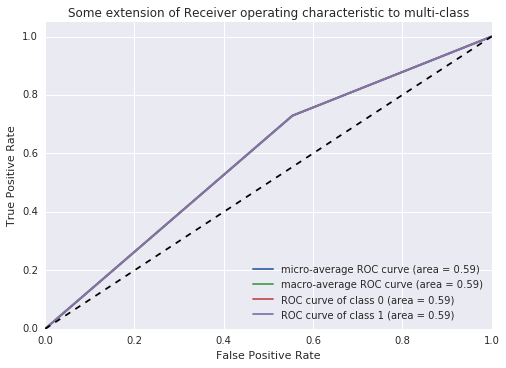

In [32]:
ROCCurves (test["Label"], predictions)

In [33]:
#let's shift the data and explore Top3, Top12 and Top25 combination for 2 days shift
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)

In [34]:
#Combination 3,12 and 25
df['Combined3_12_25']=df.iloc[:,[4,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [35]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined3_12_25']]
train.head()

,Label,Combined3_12_25
0,0.0,"[ ""b'Russia Today: Columns of troops roll into..."
1,0.0,"[ 'b""Jewish Georgian minister: Thanks to Israe..."
2,1.0,"['b\'""If we had no sexual harassment we would ..."
3,1.0,"[""b' Israel clears troops who killed Reuters c..."
4,0.0,"[ ""b'Swedish wrestler Ara Abrahamian throws aw..."


In [36]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Combined3_12_25']]
test.tail()

,Label,Combined3_12_25
1982,0.0,['Report: China is still harvesting organs fro...
1983,1.0,[ 'Nicola Sturgeon says a second independence ...
1984,1.0,"[""Poland 'shocked' by xenophobic abuse of Pole..."
1985,1.0,"[""S&amp;P cuts United Kingdom sovereign credit..."
1986,1.0,['UK must accept freedom of movement to access...


In [37]:
#no changes in the pipeline. We just use other data sets
#Combined Top3, Top12 and Top25, 3-days shift
bnb_2ngram_pipeline.fit(train['Combined3_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25
             precision    recall  f1-score   support

        0.0       0.61      0.50      0.55       185
        1.0       0.58      0.69      0.63       191

avg / total       0.59      0.59      0.59       376

Confussion matrix:
 [[ 92  93]
 [ 60 131]]
ROC-AUC: 0.591580585821


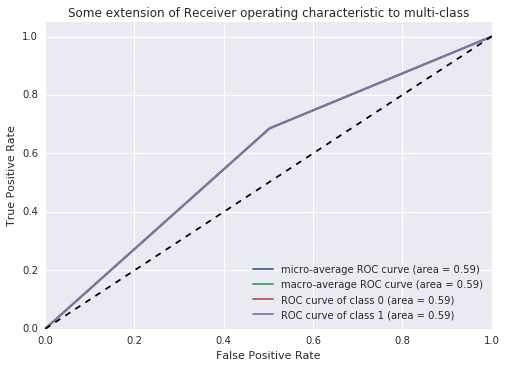

In [38]:
ROCCurves (test["Label"], predictions)

In [39]:
#let's shift the data and explore Top1 and Top6 combination for 3 days shift
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)

In [40]:
#Combination 1 and 6
df['Combined1_6']=df.iloc[:,[2,7]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [41]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined1_6']]
train.head()

,Label,Combined1_6
0,0.0,"[ 'b""Georgia \'downs two Russian warplanes\' a..."
1,1.0,"[ ""b'Why wont America and Nato help us? If the..."
2,1.0,"[ ""b'Remember that adorable 9-year-old who san..."
3,0.0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,0.0,"[""b'All the experts admit that we should legal..."


In [42]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Combined1_6']]
test.tail()

,Label,Combined1_6
1981,0.0,['German government agrees to ban fracking ind...
1982,1.0,[ 'Today The United Kingdom decides whether to...
1983,1.0,['David Cameron to Resign as PM After EU Refer...
1984,1.0,[ 'Barclays and RBS shares suspended from trad...
1985,1.0,"[ '2,500 Scientists To Australia: If You Want ..."


In [43]:
#no changes in the pipeline. We just use other data sets
#Combined Top1 and Top6, 3-days shift
bnb_2ngram_pipeline.fit(train['Combined1_6'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined1_6'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2),Combined Top1 and Top6',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
3-days shift, ngram_range=(1, 2),Combined Top1 and Top6
             precision    recall  f1-score   support

        0.0       0.57      0.42      0.49       184
        1.0       0.56      0.70      0.62       191

avg / total       0.56      0.56      0.55       375

Confussion matrix:
 [[ 78 106]
 [ 58 133]]
ROC-AUC: 0.560124061006


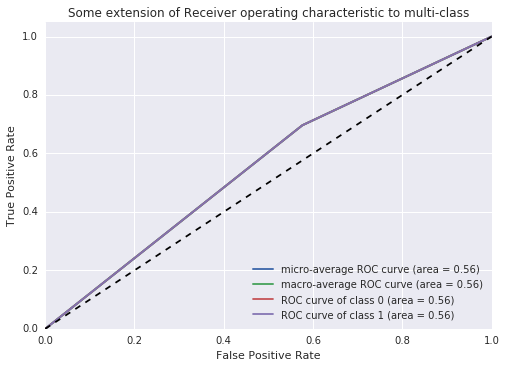

In [44]:
ROCCurves (test["Label"], predictions)

**Score Summary by Method**

In [45]:
df_ScoreSummaryByMethod=DataFrame(ScoreSummaryByMethod,columns=['Method','Comment','ROC_AUC','Precision','Accuracy','Recall','F1'])
df_ScoreSummaryByMethod.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_ScoreSummaryByMethod.head(20)

,Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1
8,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.591581,0.584821,0.593085,0.685864,0.631325
7,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Combined Top10 an...",0.587702,0.576132,0.589947,0.729167,0.643678
6,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Combined Top12 an...",0.572665,0.569507,0.574074,0.661458,0.612048
9,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2),Combined Top1...",0.560124,0.556485,0.562667,0.696335,0.618605
5,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Top25 only",0.558720,0.554167,0.560847,0.692708,0.615741
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.551872,0.549180,0.554667,0.701571,0.616092
2,"BernoulliNB(alpha=0.0,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",0.551723,0.763158,0.546419,0.151832,0.253275
4,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Top1 only",0.508989,0.515419,0.510582,0.609375,0.558473
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.500000,0.507937,0.507937,1.000000,0.673684
1,BernoulliNB(binarize=0.0),"default alpha=1,no shift, ngram_range=(1, 2), ...",0.495464,0.505051,0.500000,0.781250,0.613497
